Dataset shape: (125, 28)
Column names after cleaning:
['Record ID', 'Hospital Type', 'Hospital Department', 'Age', 'Sex', 'Work Experience', 'Receiving ongoing nursing training sessions in Hospital', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'Q27', 'Q28']

Missing values check:
Record ID                                                  0
Hospital Type                                              0
Hospital Department                                        0
Age                                                        0
Sex                                                        0
Work Experience                                            0
Receiving ongoing nursing training sessions in Hospital    0
Q8                                                         0
Q9                                                         0
Q10                                                        0
Q11                   

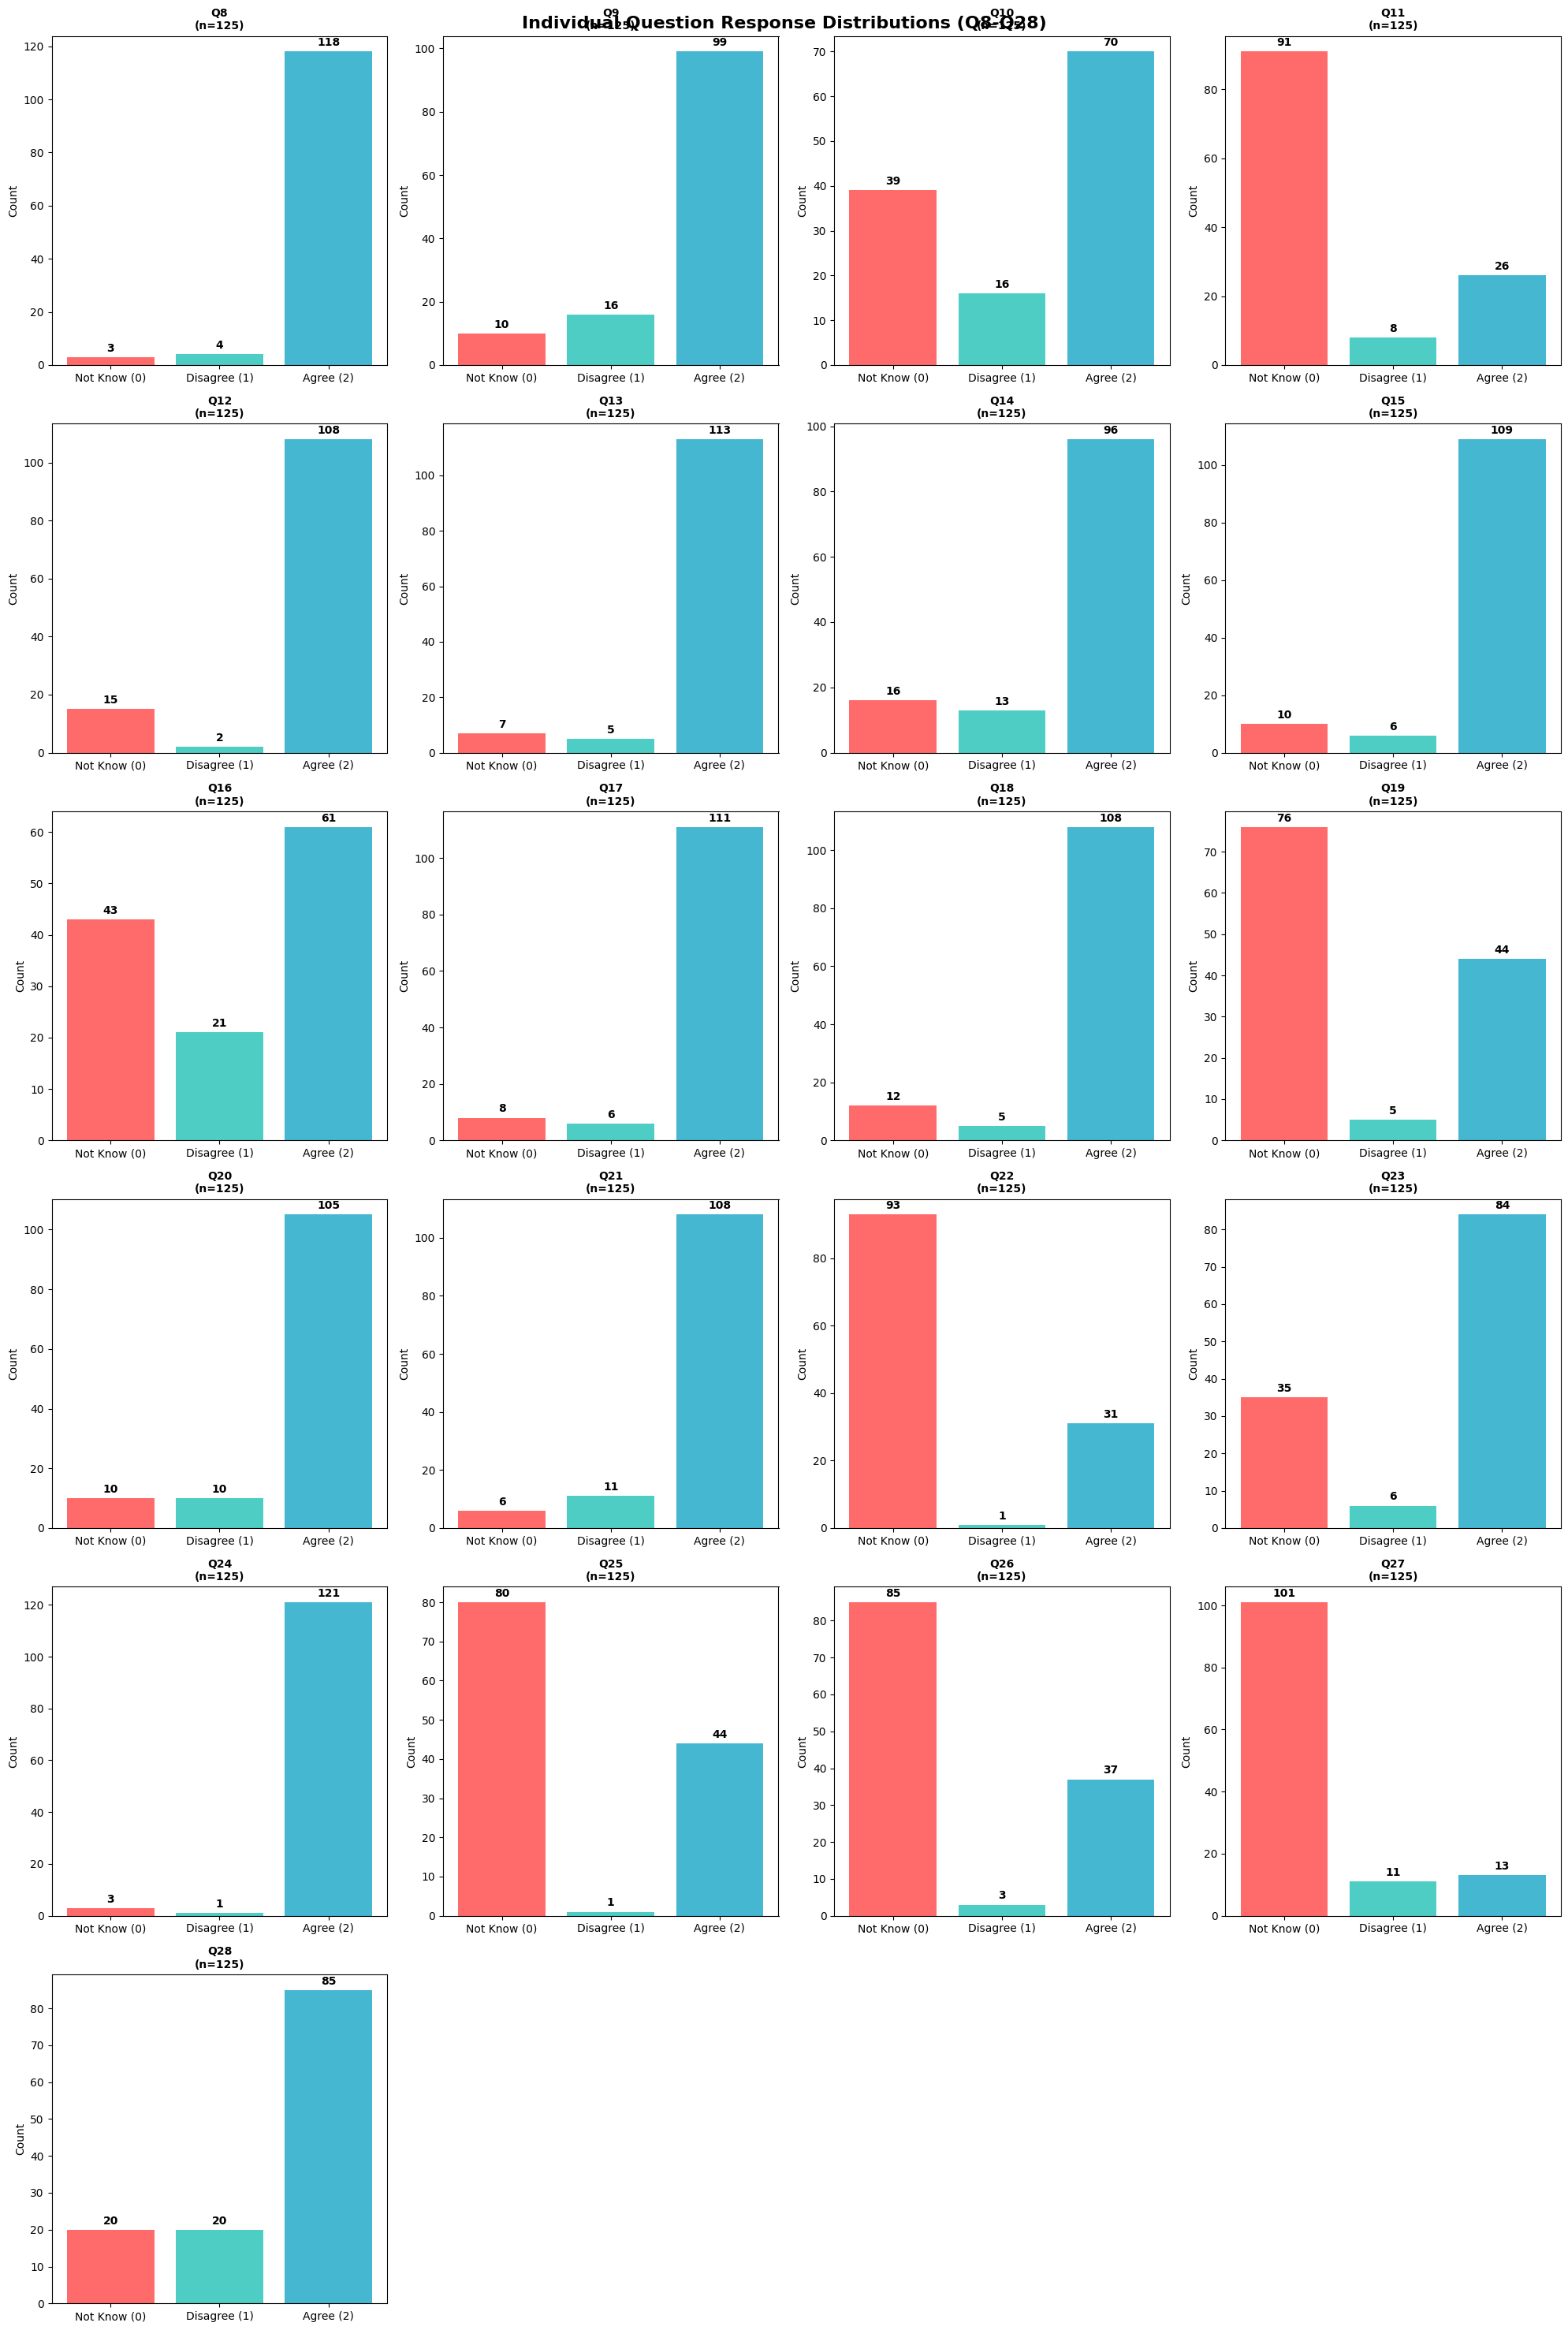


=== DEMOGRAPHIC ANALYSIS ===
Found demographic columns: ['Hospital Type', 'Hospital Department', 'Age', 'Sex', 'Work Experience', 'Receiving ongoing nursing training sessions in Hospital']


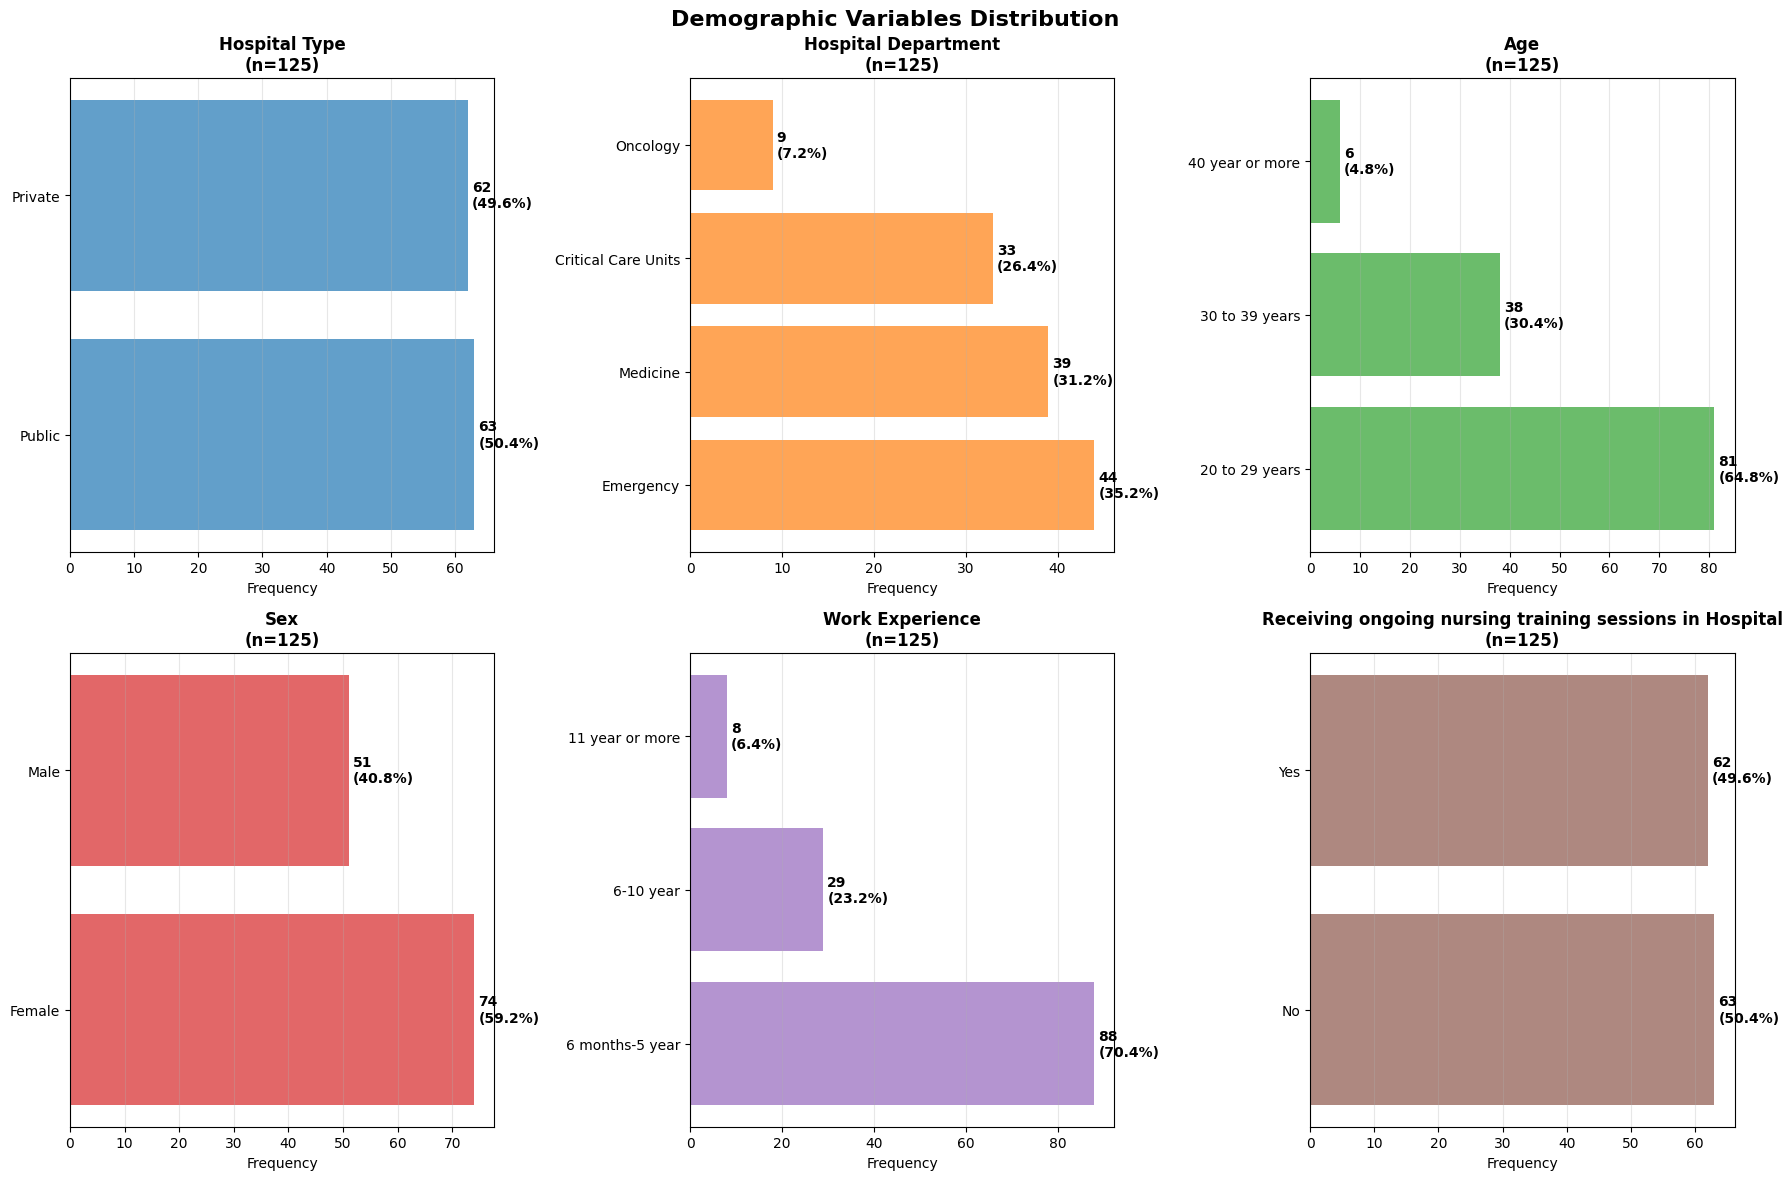


=== DESCRIPTIVE STATISTICS ===

Knowledge Score Descriptives:
count    125.000000
mean      21.440000
std        3.322455
min       13.000000
25%       20.000000
50%       22.000000
75%       24.000000
max       28.000000
Name: Knowledge_Score, dtype: float64
Range: 13 - 28

Attitude Score Descriptives:
count    125.000000
mean       3.648000
std        2.427185
min        0.000000
25%        2.000000
50%        3.000000
75%        6.000000
max       10.000000
Name: Attitude_Score, dtype: float64
Range: 0 - 10

Practice Score Descriptives:
count    125.000000
mean       3.336000
std        0.924086
min        2.000000
25%        2.000000
50%        4.000000
75%        4.000000
max        4.000000
Name: Practice_Score, dtype: float64
Range: 2 - 4

=== NORMALITY TESTS ===
Knowledge_Score: Shapiro-Wilk p-value = 0.0036
  -> Knowledge_Score is NOT normally distributed
Attitude_Score: Shapiro-Wilk p-value = 0.0000
  -> Attitude_Score is NOT normally distributed
Practice_Score: Shapiro-Wilk

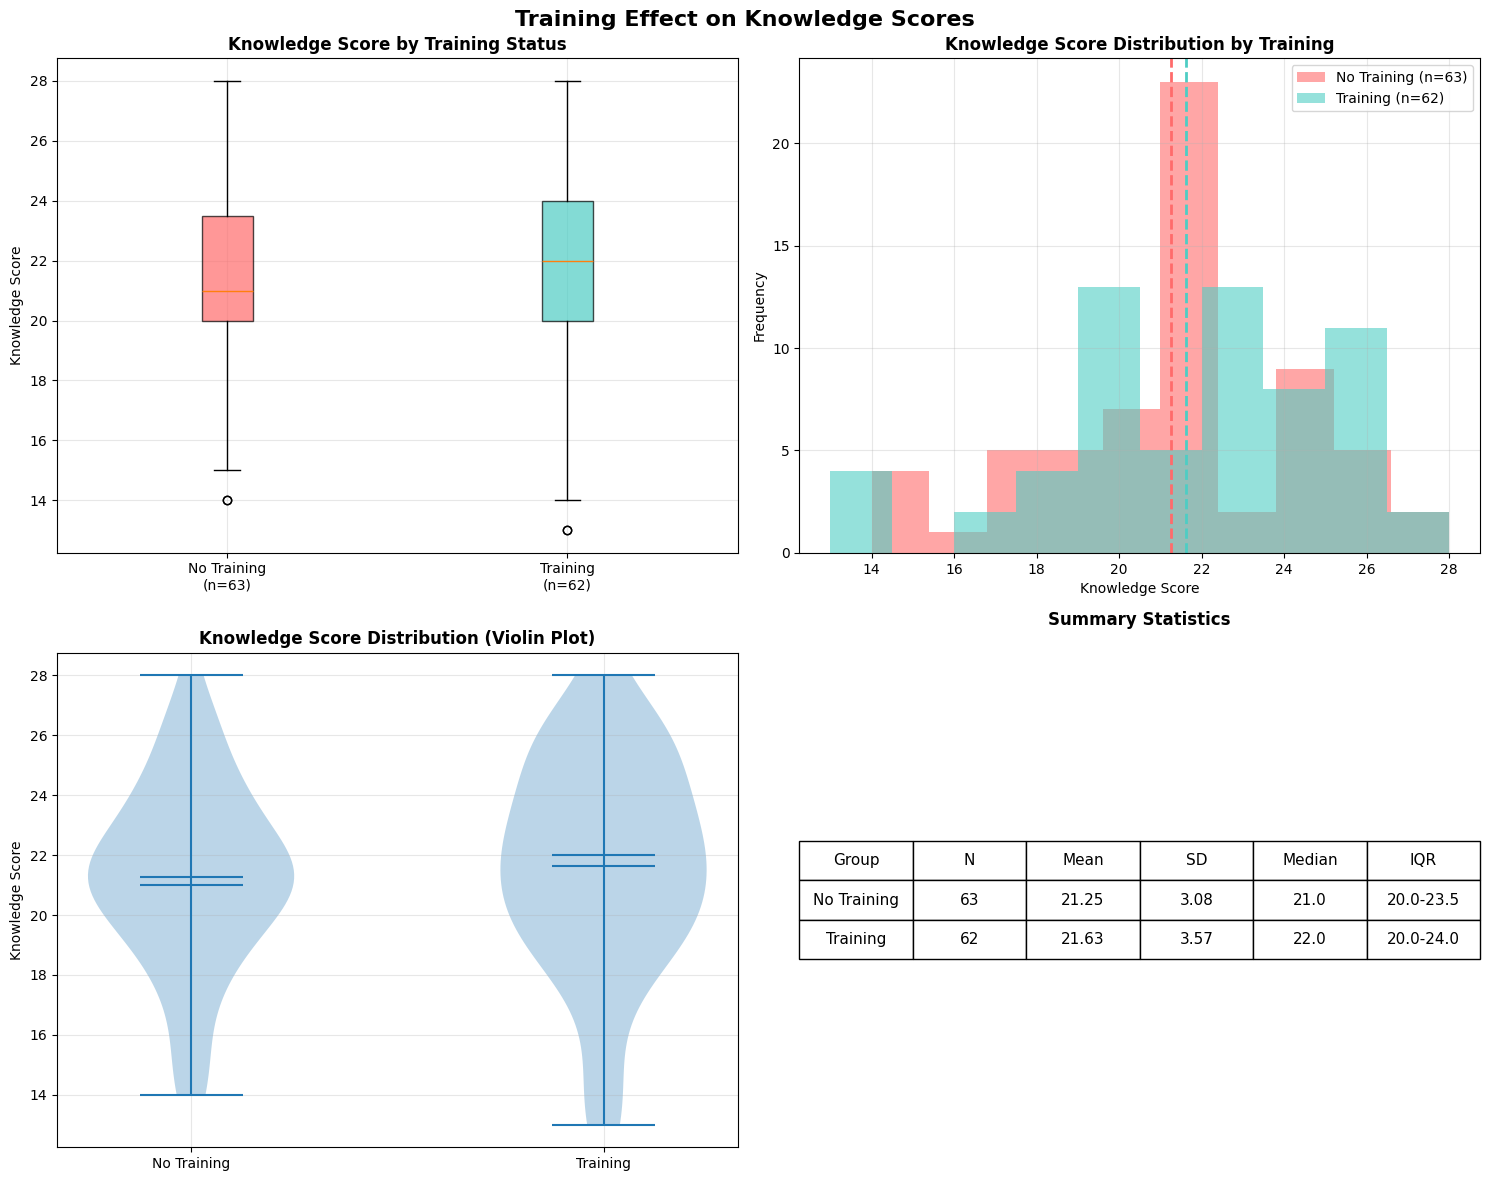


=== HOSPITAL TYPE COMPARISON ===


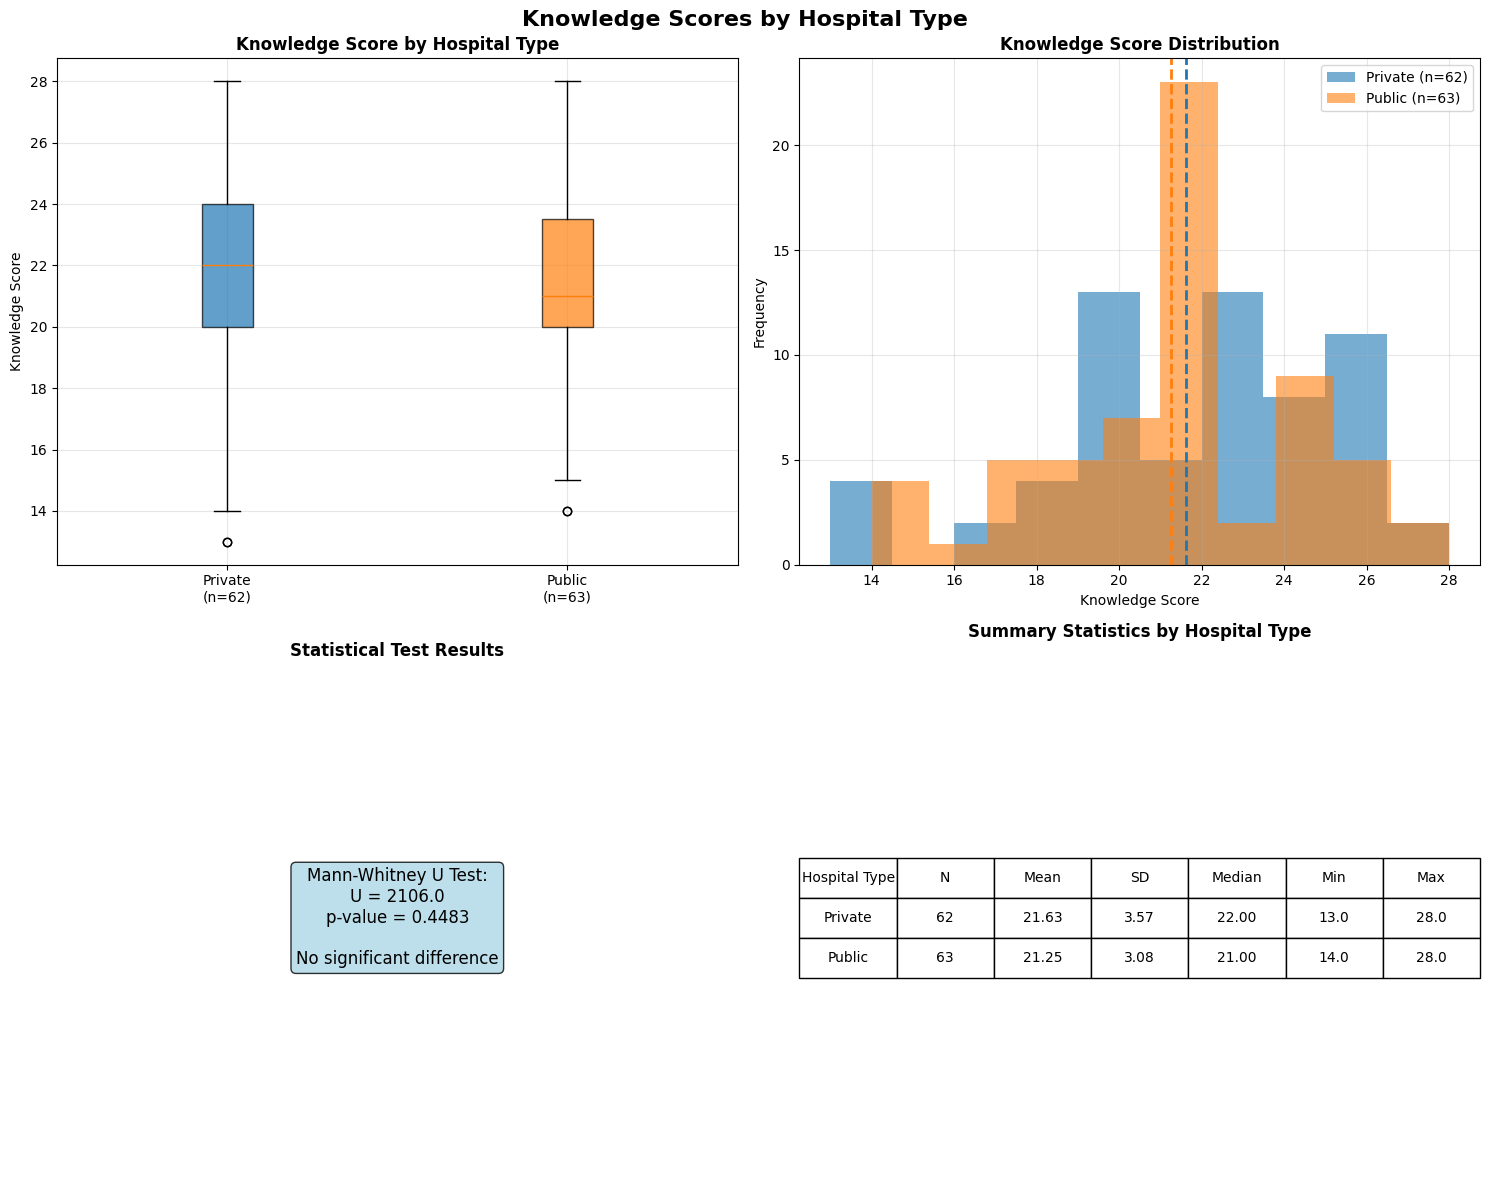


=== LOGISTIC REGRESSION ANALYSIS ===
High Knowledge cutoff: 24.0
High Knowledge distribution: High_Knowledge
0    88
1    37
Name: count, dtype: int64

Checking categorical columns:
Sex column: Sex, unique values: ['Female' 'Male']
Sex encoding: Sex_bin
1    74
0    51
Name: count, dtype: int64
Hospital type encoding: HospitalType_bin
0    63
1    62
Name: count, dtype: int64
Age column: Age, unique values: ['20 to 29 years' '30 to 39 years' '40 year or more']
Age encoding: Age_cat
1    81
2    38
3     6
Name: count, dtype: int64
Work experience column: Work Experience, unique values: ['6 months-5 year' '11 year or more' '6-10 year']
Work experience encoding: WorkExp_cat
1    88
2    29
3     8
Name: count, dtype: int64

Available predictors for logistic regression: ['Training', 'Sex_bin', 'HospitalType_bin', 'Age_cat', 'WorkExp_cat']
Complete cases for regression: 125 out of 125

Predictor correlation matrix:
                  Training   Sex_bin  HospitalType_bin   Age_cat  WorkExp_

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# -------- 1. Load dataset --------
df = pd.read_csv("/content/heatwave_data.csv")
print(f"Dataset shape: {df.shape}")

# -------- 2. Clean column names (strip whitespace) --------
df.columns = df.columns.str.strip()
print("Column names after cleaning:")
print(df.columns.tolist())

# -------- 3. Check for missing values --------
print("\nMissing values check:")
print(df.isnull().sum())



# -------- 5. Define item categories (adjust based on your actual columns) --------
knowledge_items = ["Q8","Q9","Q10","Q11","Q12","Q13","Q14","Q15","Q16","Q17","Q18","Q19","Q20","Q21"]
attitude_items  = ["Q22","Q25","Q26","Q27","Q28"]
practice_items  = ["Q23","Q24"]

# Filter to only existing columns
knowledge_items = [col for col in knowledge_items if col in df.columns]
attitude_items = [col for col in attitude_items if col in df.columns]
practice_items = [col for col in practice_items if col in df.columns]

print(f"\nKnowledge items: {knowledge_items}")
print(f"Attitude items: {attitude_items}")
print(f"Practice items: {practice_items}")

# -------- 6. Create composite scores --------
df["Knowledge_Score"] = df[knowledge_items].sum(axis=1, skipna=True)
df["Attitude_Score"] = df[attitude_items].sum(axis=1, skipna=True)
df["Practice_Score"] = df[practice_items].sum(axis=1, skipna=True)

# -------- 4. Map survey responses to numeric --------
map_values = {"Agree": 2, "Disagree": 1, "Not Know": 0}
question_cols = [f"Q{i}" for i in range(8, 29)]

existing_question_cols = [col for col in question_cols if col in df.columns]
print(f"\nFound question columns: {existing_question_cols}")

for col in existing_question_cols:
    df[col] = df[col].replace(map_values)

# 📊 VISUALIZATION 1: Individual Question Response Patterns
if len(existing_question_cols) > 0:
    n_questions = len(existing_question_cols)
    n_cols = 4
    n_rows = (n_questions + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle('Individual Question Response Distributions (Q8-Q28)', fontsize=16, fontweight='bold')

    if n_rows == 1:
        axes = axes.reshape(1, -1)

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Red, Teal, Blue
    labels = ['Not Know (0)', 'Disagree (1)', 'Agree (2)']

    for i, col in enumerate(existing_question_cols):
        row, col_idx = divmod(i, n_cols)
        ax = axes[row, col_idx]

        data = df[col].dropna()
        if len(data) > 0:
            # Determine if data is categorical or continuous
            unique_values = data.nunique()
            is_categorical = unique_values <= 10  # Threshold for categorical vs continuous

            if is_categorical:
                # Use bar chart for categorical data
                value_counts = data.value_counts().sort_index()

                # If it's the 0,1,2 scale, use custom labels and colors
                if set(data.unique()).issubset({0, 1, 2}):
                    value_counts = value_counts.reindex([0, 1, 2], fill_value=0)
                    bars = ax.bar(range(len(value_counts)), value_counts.values,
                                color=colors[:len(value_counts)])
                    ax.set_xticks(range(len(value_counts)))
                    ax.set_xticklabels(['Not Know (0)', 'Disagree (1)', 'Agree (2)'][:len(value_counts)])
                else:
                    # For other categorical data
                    bars = ax.bar(range(len(value_counts)), value_counts.values,
                                color='#45B7D1', alpha=0.7)
                    ax.set_xticks(range(len(value_counts)))
                    ax.set_xticklabels(value_counts.index, rotation=45)

                ax.set_ylabel('Count')
                ax.set_title(f'{col}\n(n={len(data)})', fontweight='bold', fontsize=10)

                # Add count labels on bars
                for bar in bars:
                    height = bar.get_height()
                    if height > 0:
                        ax.annotate(f'{int(height)}',
                                  xy=(bar.get_x() + bar.get_width() / 2, height),
                                  xytext=(0, 3),  # 3 points vertical offset
                                  textcoords="offset points",
                                  ha='center', va='bottom', fontweight='bold')

            else:
                # Use histogram for continuous data
                ax.hist(data, bins=min(20, unique_values), color='#45B7D1', alpha=0.7, edgecolor='black')
                ax.set_ylabel('Frequency')
                ax.set_xlabel('Value')
                ax.set_title(f'{col}\n(n={len(data)})', fontweight='bold', fontsize=10)

                # Add basic statistics as text
                mean_val = data.mean()
                std_val = data.std()
                ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
                ax.legend()

    # Remove empty subplots
    for i in range(len(existing_question_cols), n_rows * n_cols):
        row, col_idx = divmod(i, n_cols)
        fig.delaxes(axes[row, col_idx])

    plt.tight_layout()
    plt.savefig('02_individual_questions.png', dpi=300, bbox_inches='tight')
    plt.show()

# 📊 VISUALIZATION 2: Demographic Variables
print("\n=== DEMOGRAPHIC ANALYSIS ===")

# Find demographic columns
demographic_cols = []
demo_patterns = ['sex', 'age', 'hospital', 'department', 'experience', 'training']
for col in df.columns:
    if any(pattern in col.lower() for pattern in demo_patterns):
        demographic_cols.append(col)

print(f"Found demographic columns: {demographic_cols}")

if len(demographic_cols) > 0:
    n_demo = len(demographic_cols)
    n_cols = 3
    n_rows = (n_demo + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    fig.suptitle('Demographic Variables Distribution', fontsize=16, fontweight='bold')

    if n_rows == 1:
        axes = axes.reshape(1, -1)

    for i, col in enumerate(demographic_cols):
        if i >= n_rows * n_cols:
            break

        row, col_idx = divmod(i, n_cols)
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]

        data = df[col].dropna()
        if len(data) > 0:
            value_counts = data.value_counts()

            # Use horizontal bar for better label readability
            bars = ax.barh(range(len(value_counts)), value_counts.values,
                          color=sns.color_palette()[i % len(sns.color_palette())], alpha=0.7)

            # Add value labels
            for j, (bar, count) in enumerate(zip(bars, value_counts.values)):
                ax.text(count + max(value_counts.values)*0.01, bar.get_y() + bar.get_height()/2,
                       f'{count}\n({count/len(data)*100:.1f}%)',
                       ha='left', va='center', fontweight='bold')

            ax.set_title(f'{col}\n(n={len(data)})', fontweight='bold')
            ax.set_xlabel('Frequency')
            ax.set_yticks(range(len(value_counts)))
            ax.set_yticklabels(value_counts.index)
            ax.grid(True, alpha=0.3, axis='x')

    # Remove empty subplots
    for i in range(len(demographic_cols), n_rows * n_cols):
        row, col_idx = divmod(i, n_cols)
        if n_rows > 1:
            fig.delaxes(axes[row, col_idx])
        elif i < n_cols:
            fig.delaxes(axes[col_idx])

    plt.tight_layout()
    plt.savefig('04_demographic_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


# -------- 7. Descriptive statistics --------
print("\n=== DESCRIPTIVE STATISTICS ===")
print("\nKnowledge Score Descriptives:")
print(df["Knowledge_Score"].describe())
print(f"Range: {df['Knowledge_Score'].min()} - {df['Knowledge_Score'].max()}")

print("\nAttitude Score Descriptives:")
print(df["Attitude_Score"].describe())
print(f"Range: {df['Attitude_Score'].min()} - {df['Attitude_Score'].max()}")

print("\nPractice Score Descriptives:")
print(df["Practice_Score"].describe())
print(f"Range: {df['Practice_Score'].min()} - {df['Practice_Score'].max()}")

# -------- 8. Check normality of scores --------
print("\n=== NORMALITY TESTS ===")
for score in ['Knowledge_Score', 'Attitude_Score', 'Practice_Score']:
    stat, p_val = stats.shapiro(df[score].dropna())
    print(f"{score}: Shapiro-Wilk p-value = {p_val:.4f}")
    if p_val > 0.05:
        print(f"  -> {score} is normally distributed")
    else:
        print(f"  -> {score} is NOT normally distributed")



# -------- 8. Training effect analysis --------
print("\n=== TRAINING EFFECT ANALYSIS ===")

training_col = None
for col in df.columns:
    if "training" in col.lower():
        training_col = col
        break

if training_col:
    df['Training'] = df[training_col].map({"Yes": 1, "No": 0})
    df_train = df.dropna(subset=['Training', 'Knowledge_Score'])

    group1 = df_train[df_train['Training']==1]["Knowledge_Score"]
    group0 = df_train[df_train['Training']==0]["Knowledge_Score"]

    if len(group1) > 0 and len(group0) > 0:
        u_stat, p_val = stats.mannwhitneyu(group1, group0, alternative='two-sided')
        print(f"Mann-Whitney U test: U={u_stat}, p={p_val:.4f}")

        # 📊 VISUALIZATION 5: Training Effect
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Training Effect on Knowledge Scores', fontsize=16, fontweight='bold')

        # Box plot comparison
        training_data = [group0, group1]
        training_labels = [f'No Training\n(n={len(group0)})', f'Training\n(n={len(group1)})']
        bp = ax1.boxplot(training_data, labels=training_labels, patch_artist=True)
        colors = ['#FF6B6B', '#4ECDC4']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax1.set_title('Knowledge Score by Training Status', fontweight='bold')
        ax1.set_ylabel('Knowledge Score')
        ax1.grid(True, alpha=0.3)

        # Histograms comparison
        ax2.hist(group0, bins=10, alpha=0.6, label=f'No Training (n={len(group0)})', color=colors[0])
        ax2.hist(group1, bins=10, alpha=0.6, label=f'Training (n={len(group1)})', color=colors[1])
        ax2.axvline(group0.mean(), color=colors[0], linestyle='--', linewidth=2)
        ax2.axvline(group1.mean(), color=colors[1], linestyle='--', linewidth=2)
        ax2.set_title('Knowledge Score Distribution by Training', fontweight='bold')
        ax2.set_xlabel('Knowledge Score')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Violin plot
        parts = ax3.violinplot([group0, group1], positions=[1, 2], showmeans=True, showmedians=True)
        ax3.set_xticks([1, 2])
        ax3.set_xticklabels(['No Training', 'Training'])
        ax3.set_title('Knowledge Score Distribution (Violin Plot)', fontweight='bold')
        ax3.set_ylabel('Knowledge Score')
        ax3.grid(True, alpha=0.3)

        # Summary statistics table
        ax4.axis('off')
        summary_stats = pd.DataFrame({
            'Group': ['No Training', 'Training'],
            'N': [len(group0), len(group1)],
            'Mean': [group0.mean(), group1.mean()],
            'SD': [group0.std(), group1.std()],
            'Median': [group0.median(), group1.median()],
            'IQR': [f"{group0.quantile(0.25):.1f}-{group0.quantile(0.75):.1f}",
                   f"{group1.quantile(0.25):.1f}-{group1.quantile(0.75):.1f}"]
        })

        # Create table
        table = ax4.table(cellText=summary_stats.round(2).values,
                         colLabels=summary_stats.columns,
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)
        ax4.set_title('Summary Statistics', fontweight='bold', pad=20)

        plt.tight_layout()
        plt.savefig('05_training_effect_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

# -------- 9. Hospital type comparison --------
print("\n=== HOSPITAL TYPE COMPARISON ===")

hospital_col = None
for col in df.columns:
    if "hospital" in col.lower() and "type" in col.lower():
        hospital_col = col
        break

if hospital_col:
    df[hospital_col] = df[hospital_col].str.strip()
    df_hosp = df.dropna(subset=[hospital_col, 'Knowledge_Score'])

    hospital_types = df_hosp[hospital_col].unique()

    if len(hospital_types) > 1:
        # 📊 VISUALIZATION 6: Hospital Type Comparison
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Knowledge Scores by Hospital Type', fontsize=16, fontweight='bold')

        # Box plot
        hospital_data = []
        hospital_labels = []
        colors = sns.color_palette()[:len(hospital_types)]

        for htype in hospital_types:
            if pd.notna(htype):
                group_data = df_hosp[df_hosp[hospital_col] == htype]['Knowledge_Score']
                hospital_data.append(group_data)
                hospital_labels.append(f'{htype}\n(n={len(group_data)})')

        if hospital_data:
            bp = ax1.boxplot(hospital_data, labels=hospital_labels, patch_artist=True)
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)

        ax1.set_title('Knowledge Score by Hospital Type', fontweight='bold')
        ax1.set_ylabel('Knowledge Score')
        ax1.grid(True, alpha=0.3)

        # Histograms comparison
        for i, (htype, data) in enumerate(zip(hospital_types, hospital_data)):
            if pd.notna(htype) and len(data) > 0:
                ax2.hist(data, bins=10, alpha=0.6, label=f'{htype} (n={len(data)})', color=colors[i])
                ax2.axvline(data.mean(), color=colors[i], linestyle='--', linewidth=2)

        ax2.set_title('Knowledge Score Distribution', fontweight='bold')
        ax2.set_xlabel('Knowledge Score')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # Statistical test results
        if len(hospital_data) == 2:
            u_stat, p_val = stats.mannwhitneyu(hospital_data[0], hospital_data[1], alternative='two-sided')
            ax3.text(0.5, 0.5, f'Mann-Whitney U Test:\nU = {u_stat}\np-value = {p_val:.4f}\n\n' +
                    ('Significant difference' if p_val < 0.05 else 'No significant difference'),
                    transform=ax3.transAxes, ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        ax3.set_title('Statistical Test Results', fontweight='bold')
        ax3.axis('off')

        # Summary table
        ax4.axis('off')
        hosp_summary = []
        for htype, data in zip(hospital_types, hospital_data):
            if pd.notna(htype) and len(data) > 0:
                hosp_summary.append([
                    htype, len(data), f"{data.mean():.2f}", f"{data.std():.2f}",
                    f"{data.median():.2f}", f"{data.min():.1f}", f"{data.max():.1f}"
                ])

        if hosp_summary:
            table = ax4.table(cellText=hosp_summary,
                             colLabels=['Hospital Type', 'N', 'Mean', 'SD', 'Median', 'Min', 'Max'],
                             cellLoc='center', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 2)
        ax4.set_title('Summary Statistics by Hospital Type', fontweight='bold', pad=20)

        plt.tight_layout()
        plt.savefig('06_hospital_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

# -------- 11. Fixed logistic regression --------
print("\n=== LOGISTIC REGRESSION ANALYSIS ===")

# Create high knowledge indicator (>=75th percentile)
cutoff = df["Knowledge_Score"].quantile(0.75)
df["High_Knowledge"] = (df["Knowledge_Score"] >= cutoff).astype(int)

print(f"High Knowledge cutoff: {cutoff}")
print(f"High Knowledge distribution: {df['High_Knowledge'].value_counts()}")

# Encode categorical predictors - check column names first
print("\nChecking categorical columns:")

# Sex encoding
sex_col = None
for col in df.columns:
    if 'sex' in col.lower():
        sex_col = col
        break

if sex_col:
    print(f"Sex column: {sex_col}, unique values: {df[sex_col].unique()}")
    df['Sex_bin'] = df[sex_col].map({'Male': 0, 'Female': 1})
    print(f"Sex encoding: {df['Sex_bin'].value_counts()}")

# Hospital type encoding
if hospital_col:
    df['HospitalType_bin'] = df[hospital_col].map({'Public': 0, 'Private': 1})
    print(f"Hospital type encoding: {df['HospitalType_bin'].value_counts()}")

# Age encoding
age_col = None
for col in df.columns:
    if 'age' in col.lower():
        age_col = col
        break

if age_col:
    print(f"Age column: {age_col}, unique values: {df[age_col].unique()}")
    df['Age_cat'] = df[age_col].map({
        '20 to 29 years': 1,
        '30 to 39 years': 2,
        '40 year or more': 3
    })
    print(f"Age encoding: {df['Age_cat'].value_counts()}")

# Work experience encoding
work_exp_col = None
for col in df.columns:
    if 'work' in col.lower() or 'experience' in col.lower():
        work_exp_col = col
        break

if work_exp_col:
    print(f"Work experience column: {work_exp_col}, unique values: {df[work_exp_col].unique()}")
    df['WorkExp_cat'] = df[work_exp_col].map({
        '6 months-5 year': 1,
        '6-10 year': 2,
        '11 year or more': 3
    })
    print(f"Work experience encoding: {df['WorkExp_cat'].value_counts()}")

# -------- 12. Prepare data for logistic regression --------
# Select available predictors
available_predictors = []
if 'Training' in df.columns:
    available_predictors.append('Training')
if 'Sex_bin' in df.columns:
    available_predictors.append('Sex_bin')
if 'HospitalType_bin' in df.columns:
    available_predictors.append('HospitalType_bin')
if 'Age_cat' in df.columns:
    available_predictors.append('Age_cat')
if 'WorkExp_cat' in df.columns:
    available_predictors.append('WorkExp_cat')

print(f"\nAvailable predictors for logistic regression: {available_predictors}")

# Create dataset with complete cases only
regression_vars = available_predictors + ['High_Knowledge']
df_reg = df[regression_vars].dropna()

print(f"Complete cases for regression: {len(df_reg)} out of {len(df)}")

if len(df_reg) > 0 and len(available_predictors) > 0:
    # Check for perfect separation or multicollinearity
    X = df_reg[available_predictors]
    y = df_reg['High_Knowledge']

    print("\nPredictor correlation matrix:")
    print(X.corr())

    # Check if we have variation in the outcome
    print(f"\nOutcome distribution: {y.value_counts()}")

    # Try univariate logistic regression first
    print("\n=== UNIVARIATE LOGISTIC REGRESSION ===")
    for predictor in available_predictors:
        try:
            X_uni = df_reg[[predictor]]
            X_uni = sm.add_constant(X_uni)
            y_uni = df_reg['High_Knowledge']

            # Check for separation
            if len(X_uni[predictor].unique()) > 1 and len(y_uni.unique()) > 1:
                logit_uni = sm.Logit(y_uni, X_uni).fit(disp=0)

                coef = logit_uni.params[predictor]
                pval = logit_uni.pvalues[predictor]
                ci_lower, ci_upper = logit_uni.conf_int().loc[predictor]
                or_value = np.exp(coef)
                or_ci_lower = np.exp(ci_lower)
                or_ci_upper = np.exp(ci_upper)

                print(f"\n{predictor}:")
                print(f"  Beta coefficient: {coef:.3f}")
                print(f"  Odds ratio: {or_value:.3f} [{or_ci_lower:.3f}-{or_ci_upper:.3f}]")
                print(f"  P-value: {pval:.3f}")

        except Exception as e:
            print(f"Error with {predictor}: {str(e)}")

    # Try multivariable logistic regression with regularization
    if len(available_predictors) > 1:
        print("\n=== MULTIVARIABLE LOGISTIC REGRESSION ===")
        try:
            # Start with a simple model
            X_multi = df_reg[available_predictors[:3] if len(available_predictors) > 3 else available_predictors]
            X_multi = sm.add_constant(X_multi)

            # Add regularization parameter
            logit_multi = sm.Logit(y, X_multi).fit_regularized(alpha=0.01, disp=0)
            print("Multivariable model (regularized):")
            print(logit_multi.summary())

        except Exception as e:
            print(f"Multivariable regression error: {str(e)}")
            print("Trying stepwise approach...")

            # Try forward selection approach
            significant_predictors = []
            for predictor in available_predictors:
                try:
                    current_predictors = significant_predictors + [predictor]
                    X_step = df_reg[current_predictors]
                    X_step = sm.add_constant(X_step)
                    model_step = sm.Logit(y, X_step).fit(disp=0)

                    if model_step.pvalues[predictor] < 0.25:  # Liberal inclusion criterion
                        significant_predictors.append(predictor)
                        print(f"Added {predictor} (p={model_step.pvalues[predictor]:.3f})")

                except Exception as inner_e:
                    print(f"Could not add {predictor}: {str(inner_e)}")

            if significant_predictors:
                print(f"\nFinal model with predictors: {significant_predictors}")
                X_final = df_reg[significant_predictors]
                X_final = sm.add_constant(X_final)
                final_model = sm.Logit(y, X_final).fit(disp=0)
                print(final_model.summary())

# -------- 13. Additional descriptive analysis --------
print("\n=== ADDITIONAL DESCRIPTIVE STATISTICS ===")

# Frequency tables for categorical variables
categorical_vars = ['Sex', 'Age', 'Work Experience', 'Hospital Type', 'Hospital Department']
existing_categorical = [col for col in df.columns if any(cat.lower() in col.lower() for cat in categorical_vars)]

for col in existing_categorical[:5]:  # Limit to first 5 to avoid clutter
    if col in df.columns:
        print(f"\n{col} distribution:")
        print(df[col].value_counts())
        print("Percentages:")
        print((df[col].value_counts(normalize=True) * 100).round(1))

# -------- 14. Save cleaned dataset --------
df.to_csv("heatwave_data_cleaned.csv", index=False)
print(f"\nCleaned dataset saved to 'heatwave_data_cleaned.csv'")
print(f"Final dataset shape: {df.shape}")

# -------- 15. Summary of analysis --------
print("\n" + "="*50)
print("ANALYSIS SUMMARY")
print("="*50)
print(f"Total sample size: {len(df)}")
print(f"Knowledge items analyzed: {len(knowledge_items)}")
print(f"Attitude items analyzed: {len(attitude_items)}")
print(f"Practice items analyzed: {len(practice_items)}")
print(f"Mean Knowledge Score: {df['Knowledge_Score'].mean():.2f} ± {df['Knowledge_Score'].std():.2f}")
print(f"Mean Attitude Score: {df['Attitude_Score'].mean():.2f} ± {df['Attitude_Score'].std():.2f}")
print(f"Mean Practice Score: {df['Practice_Score'].mean():.2f} ± {df['Practice_Score'].std():.2f}")

if 'Training' in df.columns:
    print(f"Participants with training: {df['Training'].sum()} ({(df['Training'].mean()*100):.1f}%)")

print("Analysis completed successfully!")

In [ ]:
# -------- 6b. Reliability Analysis (Cronbach's Alpha) --------
def cronbach_alpha(df_subset):
    """
    Compute Cronbach's alpha for a set of items.
    df_subset: pandas DataFrame (columns = items, rows = respondents)
    """
    df_clean = df_subset.dropna()  # drop rows with any missing
    k = df_clean.shape[1]
    if k < 2:
        return np.nan  # not enough items

    item_variances = df_clean.var(axis=0, ddof=1)
    total_score = df_clean.sum(axis=1)
    total_variance = total_score.var(ddof=1)

    if total_variance == 0:
        return np.nan

    alpha = (k / (k - 1)) * (1 - item_variances.sum() / total_variance)
    return alpha

# Calculate Cronbach's alpha for each construct (if items exist)
print("\n=== RELIABILITY (CRONBACH'S ALPHA) ===")
if knowledge_items:
    alpha_knowledge = cronbach_alpha(df[knowledge_items])
    print(f"Knowledge scale (items={len(knowledge_items)}): α = {alpha_knowledge:.3f}")
if attitude_items:
    alpha_attitude = cronbach_alpha(df[attitude_items])
    print(f"Attitude scale (items={len(attitude_items)}): α = {alpha_attitude:.3f}")
if practice_items:
    alpha_practice = cronbach_alpha(df[practice_items])
    print(f"Practice scale (items={len(practice_items)}): α = {alpha_practice:.3f}")



=== RELIABILITY (CRONBACH'S ALPHA) ===
Knowledge scale (items=14): α = 0.449
Attitude scale (items=5): α = 0.508
Practice scale (items=2): α = -0.123


In [ ]:
!pip install pingouin

import pingouin as pg

# Using the same knowledge items
alpha, _ = pg.cronbach_alpha(df[knowledge_items])
print("Cronbach's alpha:", round(alpha, 3))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 13.2 MB/s eta 0:00:00
Cronbach's alpha: 0.449


In [ ]:
# -------- 7b. Hypothesis Testing --------
print("\n=== HYPOTHESIS TESTING ===")

# Example Hypotheses:
# H0: Mean Knowledge Score = Mean Attitude Score
# H1: Means are different

# Paired test between Knowledge and Attitude
if df['Knowledge_Score'].notna().sum() > 0 and df['Attitude_Score'].notna().sum() > 0:
    # First check normality of the difference
    diff = df['Knowledge_Score'] - df['Attitude_Score']
    shapiro_stat, shapiro_p = stats.shapiro(diff.dropna())

    if shapiro_p > 0.05:
        # Use paired t-test (parametric)
        t_stat, p_val = stats.ttest_rel(df['Knowledge_Score'], df['Attitude_Score'], nan_policy='omit')
        print(f"Paired t-test (Knowledge vs Attitude): t={t_stat:.3f}, p={p_val:.4f}")
    else:
        # Use Wilcoxon signed-rank test (non-parametric)
        w_stat, p_val = stats.wilcoxon(df['Knowledge_Score'], df['Attitude_Score'])
        print(f"Wilcoxon signed-rank (Knowledge vs Attitude): W={w_stat}, p={p_val:.4f}")

# Compare Knowledge vs Practice
if df['Knowledge_Score'].notna().sum() > 0 and df['Practice_Score'].notna().sum() > 0:
    diff = df['Knowledge_Score'] - df['Practice_Score']
    shapiro_stat, shapiro_p = stats.shapiro(diff.dropna())

    if shapiro_p > 0.05:
        t_stat, p_val = stats.ttest_rel(df['Knowledge_Score'], df['Practice_Score'], nan_policy='omit')
        print(f"Paired t-test (Knowledge vs Practice): t={t_stat:.3f}, p={p_val:.4f}")
    else:
        w_stat, p_val = stats.wilcoxon(df['Knowledge_Score'], df['Practice_Score'])
        print(f"Wilcoxon signed-rank (Knowledge vs Practice): W={w_stat}, p={p_val:.4f}")

# Independent test: Male vs Female Knowledge Score
if 'Sex_bin' in df.columns:
    male_scores = df[df['Sex_bin']==0]['Knowledge_Score'].dropna()
    female_scores = df[df['Sex_bin']==1]['Knowledge_Score'].dropna()
    if len(male_scores) > 0 and len(female_scores) > 0:
        # Normality check
        if stats.shapiro(male_scores)[1] > 0.05 and stats.shapiro(female_scores)[1] > 0.05:
            t_stat, p_val = stats.ttest_ind(male_scores, female_scores, equal_var=False)
            print(f"Independent t-test (Male vs Female Knowledge): t={t_stat:.3f}, p={p_val:.4f}")
        else:
            u_stat, p_val = stats.mannwhitneyu(male_scores, female_scores, alternative='two-sided')
            print(f"Mann-Whitney U (Male vs Female Knowledge): U={u_stat}, p={p_val:.4f}")



=== HYPOTHESIS TESTING ===
Wilcoxon signed-rank (Knowledge vs Attitude): W=0.0, p=0.0000
Wilcoxon signed-rank (Knowledge vs Practice): W=0.0, p=0.0000
Mann-Whitney U (Male vs Female Knowledge): U=1694.0, p=0.3302
